# CVE Prophet Notebook CPE Prediction

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic time series forecasting using [Prophet](https://facebook.github.io/prophet/) from Facebook.  

## Getting Started

### Retrieve The Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!pip3 install prophet
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2016..2021}.json.zip 
!unzip -o "*.zip" 

(Note: The Output of this cell is hidden with `%%capture`)

### Import Python Libraries 

In [2]:
import calplot
import glob
import json
import logging
import sys
import numpy as np
import os
import pandas as pd
import re
import uuid
from datetime import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from scipy import stats
logging.disable(sys.maxsize)

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [3]:
row_accumulator = []
for filename in glob.glob('*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvd['Published'] = pd.to_datetime(nvd['Published'], errors='coerce')
print ('CVEs from NVD:', nvd['CVE'].count())
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
per_day = nvdcount/nvdunique
per_day = round(per_day, 0)
print('CVEs Published Per Publishing Day:', per_day)

CVEs from NVD: 78952
CVEs Published Per Publishing Day: 44.0


(Note: The code for building this dataframe is based off the great work in this [repo](https://github.com/joocer/mitre-tools/blob/74a08bca9e79f2c18cc4e8671d1d7da5b43a2dd4/source/data/02%20process_rawdata.py))

### Build Base DataFrame For Prophet 

In [4]:
selected_columns = nvd[["Published","BaseScore"]]
cvss_df = selected_columns.copy()
cvss_df.rename(columns={'Published':'ds', 'BaseScore':'y'},inplace=True)
cvss_df = cvss_df.replace("Missing_Data_JG", np.nan)
cvss_df = cvss_df.dropna()
cvss_df

,ds,y
0,2016-01-13,7.5
1,2016-01-13,9.6
2,2016-01-13,4.3
3,2016-01-13,7.3
4,2016-01-13,7.8
...,...,...
78947,2020-10-22,7.1
78948,2021-04-02,6.1
78949,2020-12-08,7.8
78950,2020-10-22,5.5


### Build The Future Dataframe

In [5]:
m = Prophet()
m.fit(cvss_df)
future = m.make_future_dataframe(periods=1825)

This shows the plot for all previous data and the next 5 years. 

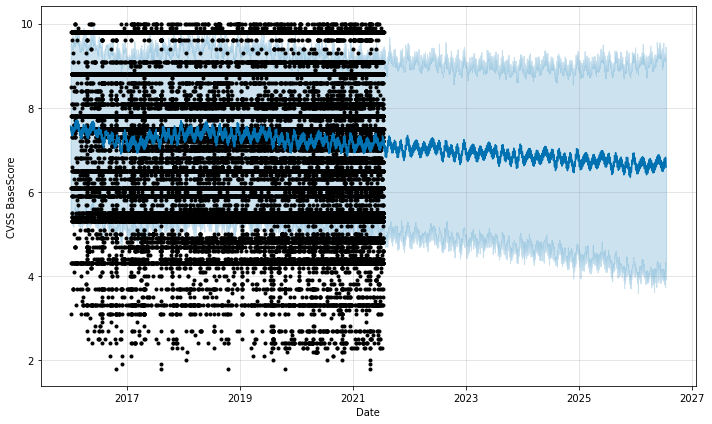

In [6]:
forecast = m.predict(future)
fig = m.plot(forecast, xlabel='Date', ylabel='CVSS BaseScore')
fig.savefig('./forecast_cvss.jpg', dpi=300, bbox_inches='tight')

### Plot the Forecast With Change Points

This shows the plot for all previous data and the next 10 years with changepoints marked where the data had abrupt changes in its trajectories.

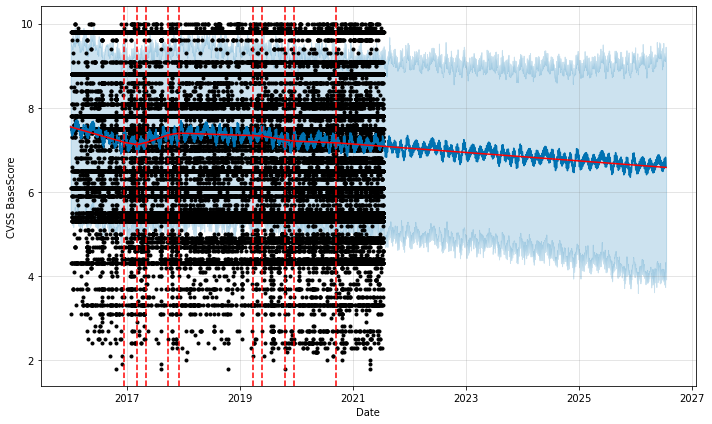

In [7]:
fig = m.plot(forecast, xlabel='Date', ylabel='CVSS BaseScore')
a = add_changepoints_to_plot(fig.gca(), m, forecast)
fig.savefig('./forecast_changepoints_cvss.jpg', dpi=300, bbox_inches='tight')

### CVSS Score Predictions

In [33]:
cve_prophet_thisyear = forecast[(forecast['ds'] > '2021-07-18') & (forecast['ds'] < '2021-12-31')]
cve_prophet_next5 = forecast[(forecast['ds'] > '2021-07-18') & (forecast['ds'] < '2026-12-31')]
cvss_avg = cvss_df['y'].mean()
cvss_year= cve_prophet_thisyear['yhat'].mean()
cvss_5year = cve_prophet_next5['yhat'].mean()
print('Average CVSS Score For All CVEs:', round(cvss_avg,2))
print('Predicted Average CVSS Score For The Rest Of The Year:', round(cvss_year,2))
print('Predicted Average CVSS Score For Next 5 Years:', round(cvss_5year,2))


Average CVSS Score For All CVEs: 7.22
Predicted Average CVSS Score For The Rest Of The Year: 7.04
Predicted Average CVSS Score For Next 5 Years: 6.83
